## In this notebook

- Run model training process.
- Overall goal of the task: Predict electronic vehicles charging stations availability in Paris.
- There are four target columns:
    - `Available`: how many plugs are available at time t for the station k,
    - `Charging`: how many plugs are occupied and charging at time t for the station k,
    - `Passive`: how many plugs are occupied but not charging at time t for the station k,
    - `Other`: how many plugs are either offline or out of order at time t for the station k.
- Used [this tutorial](https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e).

In [ ]:
import os

# analytics
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np

# model
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score,
)
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential, load_model
from keras import Input
from keras.layers import Bidirectional, Dense, LSTM, RepeatVector, TimeDistributed


# plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [ ]:
DATA_FOLDER = "../data"

TIMESTEP = 96
MAX_DATA_POINTS = 10_000

# Y_COLUMN = "available"
# Y_COLUMN = "charging"
Y_COLUMN = "passive"

MODEL_INDEX = 1

In [ ]:
! ls -l $DATA_FOLDER

## Load data

In [5]:
# load train data

df = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
df.columns = [col.lower() for col in df.columns]

df.tail()

,date,station,available,charging,passive,other,tod,dow,trend,latitude,longitude,postcode,area
1851078,2021-02-18 23:45:00,FR*V75*EBELI*95*1,0,0,0,3,95,5,22202,48.86851,2.295469,75016,west
1851079,2021-02-18 23:45:00,FR*V75*EBELI*96*1,2,1,0,0,95,5,22202,48.83550,2.349650,75013,south
1851080,2021-02-18 23:45:00,FR*V75*EBELI*97*1,1,1,1,0,95,5,22202,48.83995,2.397822,75012,east
1851081,2021-02-18 23:45:00,FR*V75*EBELI*98*1,2,0,1,0,95,5,22202,48.84998,2.361920,75004,south
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,3,0,0,0,95,5,22202,48.87780,2.391820,75019,east


In [6]:
# leave only one target in the data set

df = df.loc[:, ["date", "station", Y_COLUMN]]
df = df.sort_values(by="date").reset_index(drop=True)

df.tail()

,date,station,passive
1851078,2021-02-18 23:45:00,FR*V75*EBELI*32*1,0
1851079,2021-02-18 23:45:00,FR*V75*EBELI*31*1,0
1851080,2021-02-18 23:45:00,FR*V75*EBELI*30*1,1
1851081,2021-02-18 23:45:00,FR*V75*EBELI*39*1,1
1851082,2021-02-18 23:45:00,FR*V75*EBELI*99*1,0


## Prepare data for model

- Reshape data into `TIMESTEP` long slided windows, for both X and Y.
- Example `TIMESTEP = 4`:

```
+----------------------+----------------------+
| X                    | y                    |
+----------------------+----------------------+
| x_1, x_2, x_3, x_4   | x_5, x_6, x_7, x_8   |
| x_2, x_3, x_4, x_5   | x_6, x_7, x_8, x_9   |
| x_3, x_4, x_5, x_6   | x_7, x_8, x_9, x_10  |
-----------------------+----------------------+
```

In [7]:
%%time

X = []
y = []
window_size = 2 * TIMESTEP

for station in df.station.unique():
    target_col_array = (
        df
        .loc[df.station == station, Y_COLUMN]
        .values
    )
    
    for j in range(len(target_col_array) - window_size + 1):
        window = target_col_array[j: j + window_size]
        X.append(window[:TIMESTEP])
        y.append(window[TIMESTEP:])


# TODO: delete this data filtering (!!!)
# X = X[:MAX_DATA_POINTS]
# y = y[:MAX_DATA_POINTS]
X = X[(MODEL_INDEX * MAX_DATA_POINTS): ((MODEL_INDEX + 1) * MAX_DATA_POINTS)]
y = y[(MODEL_INDEX * MAX_DATA_POINTS): ((MODEL_INDEX + 1) * MAX_DATA_POINTS)]

X = np.reshape(X, (len(X), TIMESTEP, 1))
y = np.reshape(y, (len(y), TIMESTEP, 1))    

print(X.shape)
print(y.shape)

(10000, 96, 1)
(10000, 96, 1)
CPU times: user 6.27 s, sys: 79.6 ms, total: 6.35 s
Wall time: 6.34 s


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build model

In [9]:
# run model

# specify the architecture of LSTM
model = Sequential(name="LSTM-Model")
model.add(Input(shape=(X_train.shape[1], X_train.shape[2]), name="Input-Layer"))
model.add(Bidirectional(
    LSTM(units=32, activation="tanh", recurrent_activation="sigmoid", stateful=False), 
    name="Hidden-LSTM-Encoder-Layer",
))
model.add(RepeatVector(y_train.shape[1], name="Repeat-Vector-Layer"))
model.add(Bidirectional(
    LSTM(units=32, activation="tanh", recurrent_activation="sigmoid", stateful=False, return_sequences=True), 
    name="Hidden-LSTM-Decoder-Layer",
))
model.add(TimeDistributed(Dense(units=1, activation="linear"), name="Output-Layer"))


# compile the model
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["MeanSquaredError", "MeanAbsoluteError"],
    loss_weights=None,
    run_eagerly=None,
    steps_per_execution=None
)

# fit model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    # epochs=1000, 
    epochs=150,
    validation_split=0.2,
    workers=4,
    use_multiprocessing=True,
)

Epoch 1/150
200/200 [==============================] - 7s 27ms/step - loss: 0.1380 - mean_squared_error: 0.1380 - mean_absolute_error: 0.2139 - val_loss: 0.1237 - val_mean_squared_error: 0.1237 - val_mean_absolute_error: 0.2104
Epoch 2/150
200/200 [==============================] - 5s 24ms/step - loss: 0.1332 - mean_squared_error: 0.1332 - mean_absolute_error: 0.2080 - val_loss: 0.1194 - val_mean_squared_error: 0.1194 - val_mean_absolute_error: 0.1875
Epoch 3/150
200/200 [==============================] - 5s 25ms/step - loss: 0.1316 - mean_squared_error: 0.1316 - mean_absolute_error: 0.2070 - val_loss: 0.1182 - val_mean_squared_error: 0.1182 - val_mean_absolute_error: 0.1898
Epoch 4/150
200/200 [==============================] - 5s 25ms/step - loss: 0.1292 - mean_squared_error: 0.1292 - mean_absolute_error: 0.2040 - val_loss: 0.1199 - val_mean_squared_error: 0.1199 - val_mean_absolute_error: 0.1945
Epoch 5/150
200/200 [==============================] - 5s 25ms/step - loss: 0.1305 - mea

Epoch 37/150
200/200 [==============================] - 5s 27ms/step - loss: 0.1041 - mean_squared_error: 0.1041 - mean_absolute_error: 0.1776 - val_loss: 0.0947 - val_mean_squared_error: 0.0947 - val_mean_absolute_error: 0.1740
Epoch 38/150
200/200 [==============================] - 5s 26ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - mean_absolute_error: 0.1772 - val_loss: 0.0956 - val_mean_squared_error: 0.0956 - val_mean_absolute_error: 0.1801
Epoch 39/150
200/200 [==============================] - 5s 27ms/step - loss: 0.1037 - mean_squared_error: 0.1037 - mean_absolute_error: 0.1770 - val_loss: 0.0908 - val_mean_squared_error: 0.0908 - val_mean_absolute_error: 0.1717
Epoch 40/150
200/200 [==============================] - 5s 26ms/step - loss: 0.1006 - mean_squared_error: 0.1006 - mean_absolute_error: 0.1742 - val_loss: 0.0923 - val_mean_squared_error: 0.0923 - val_mean_absolute_error: 0.1796
Epoch 41/150
200/200 [==============================] - 5s 27ms/step - loss: 0.1023 

Epoch 73/150
200/200 [==============================] - 5s 27ms/step - loss: 0.1073 - mean_squared_error: 0.1073 - mean_absolute_error: 0.1808 - val_loss: 0.1015 - val_mean_squared_error: 0.1015 - val_mean_absolute_error: 0.1734
Epoch 74/150
200/200 [==============================] - 6s 28ms/step - loss: 0.1057 - mean_squared_error: 0.1057 - mean_absolute_error: 0.1795 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - val_mean_absolute_error: 0.1542
Epoch 75/150
200/200 [==============================] - 5s 27ms/step - loss: 0.1029 - mean_squared_error: 0.1029 - mean_absolute_error: 0.1759 - val_loss: 0.0953 - val_mean_squared_error: 0.0953 - val_mean_absolute_error: 0.1540
Epoch 76/150
200/200 [==============================] - 5s 27ms/step - loss: 0.0988 - mean_squared_error: 0.0988 - mean_absolute_error: 0.1726 - val_loss: 0.1030 - val_mean_squared_error: 0.1030 - val_mean_absolute_error: 0.1637
Epoch 77/150
200/200 [==============================] - 6s 28ms/step - loss: 0.1033 

Epoch 109/150
200/200 [==============================] - 6s 28ms/step - loss: 0.1167 - mean_squared_error: 0.1167 - mean_absolute_error: 0.1892 - val_loss: 0.1057 - val_mean_squared_error: 0.1057 - val_mean_absolute_error: 0.1638
Epoch 110/150
200/200 [==============================] - 6s 29ms/step - loss: 0.1138 - mean_squared_error: 0.1138 - mean_absolute_error: 0.1870 - val_loss: 0.1027 - val_mean_squared_error: 0.1027 - val_mean_absolute_error: 0.1905
Epoch 111/150
200/200 [==============================] - 6s 29ms/step - loss: 0.1123 - mean_squared_error: 0.1123 - mean_absolute_error: 0.1854 - val_loss: 0.1010 - val_mean_squared_error: 0.1010 - val_mean_absolute_error: 0.1719
Epoch 112/150
200/200 [==============================] - 6s 29ms/step - loss: 0.1115 - mean_squared_error: 0.1115 - mean_absolute_error: 0.1839 - val_loss: 0.1001 - val_mean_squared_error: 0.1001 - val_mean_absolute_error: 0.1824
Epoch 113/150
200/200 [==============================] - 6s 29ms/step - loss: 0.

Epoch 145/150
200/200 [==============================] - 6s 29ms/step - loss: 0.0845 - mean_squared_error: 0.0845 - mean_absolute_error: 0.1548 - val_loss: 0.0800 - val_mean_squared_error: 0.0800 - val_mean_absolute_error: 0.1673
Epoch 146/150
200/200 [==============================] - 6s 29ms/step - loss: 0.0857 - mean_squared_error: 0.0857 - mean_absolute_error: 0.1568 - val_loss: 0.0787 - val_mean_squared_error: 0.0787 - val_mean_absolute_error: 0.1331
Epoch 147/150
200/200 [==============================] - 6s 29ms/step - loss: 0.0839 - mean_squared_error: 0.0839 - mean_absolute_error: 0.1536 - val_loss: 0.0793 - val_mean_squared_error: 0.0793 - val_mean_absolute_error: 0.1646
Epoch 148/150
200/200 [==============================] - 6s 29ms/step - loss: 0.0849 - mean_squared_error: 0.0849 - mean_absolute_error: 0.1555 - val_loss: 0.0782 - val_mean_squared_error: 0.0782 - val_mean_absolute_error: 0.1444
Epoch 149/150
200/200 [==============================] - 6s 29ms/step - loss: 0.

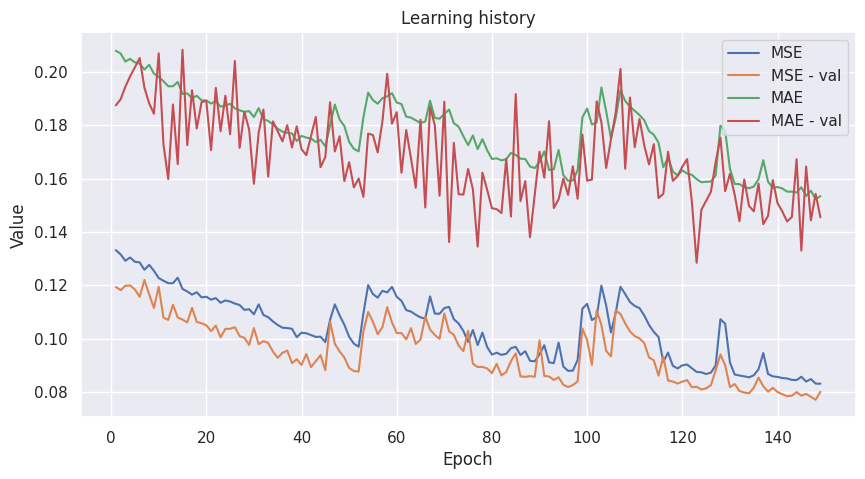

In [10]:
df_history = pd.DataFrame({
    # "loss": history.history["loss"],
    "MSE": history.history["mean_squared_error"],
    "MSE - val": history.history["val_mean_squared_error"],
    "MAE": history.history["mean_absolute_error"],
    "MAE - val": history.history["val_mean_absolute_error"],
})

ax = df_history.iloc[1:].plot(title="Learning history")
ax.set_xlabel("Epoch")
ax.set_ylabel("Value")

plt.show()

## Validate model

In [11]:
# check performance on test dataset

y_test_pred = np.round(
    np.clip(
        model.predict(X_test).reshape(1, -1)[0],
        a_min=0,
        a_max=3,
    )
)
y_test = y_test.reshape(1, -1)[0]

print("Results:")
print(f"- accuracy: {accuracy_score(y_test, y_test_pred):,.3f}")
print(f"- precision: {precision_score(y_test, y_test_pred, average='weighted', zero_division=0):,.3f}")
print(f"- recall: {recall_score(y_test, y_test_pred, average='weighted'):,.3f}")
print(f"- F1: {f1_score(y_test, y_test_pred, average='weighted'):,.3f}")
print()
print(f"- confusion matrix: \n{confusion_matrix(y_test, y_test_pred)}")

63/63 [==============================] - 1s 9ms/step
Results:
- accuracy: 0.913
- precision: 0.898
- recall: 0.913
- F1: 0.890

- confusion matrix: 
[[170104    962     13      0]
 [ 14228   3581    273      0]
 [   624    508   1598      9]
 [    16      4     70     10]]


<AxesSubplot: >

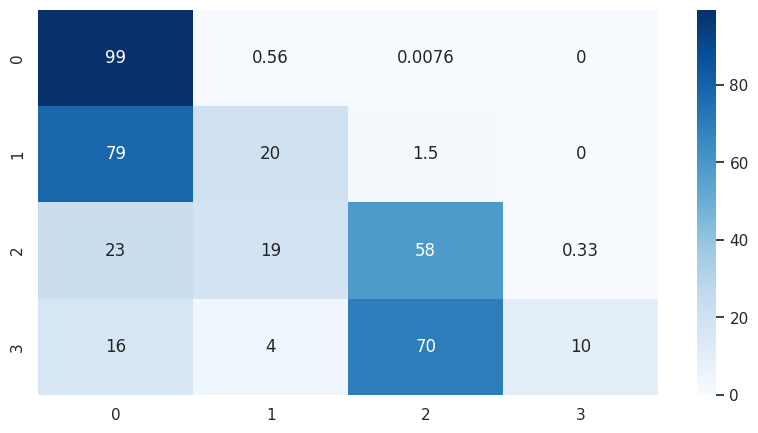

In [12]:
# check confusion matrix (with shares in every true class=rows)

cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(
    cm / cm.sum(axis=1).reshape(-1, 1) * 100, 
    annot=True,
    cmap='Blues',
)

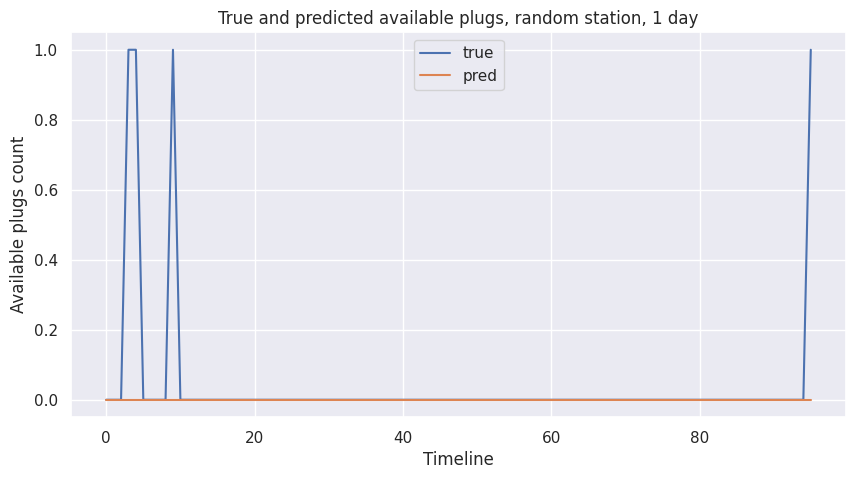

In [13]:
# check comparison of true and predicted available plugs

df_results = pd.DataFrame({
    "true": y_test,
    "pred": y_test_pred,
})

# ax = df_results.plot(alpha=0.75)
ax = df_results.head(96).plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs count")
ax.set_title("True and predicted available plugs, random station, 1 day")

plt.show()

## Try to predict one station for the next 7 days

In [14]:
DATA_POINTS_TO_PREDICT = 96 * 7

In [15]:
%%time

most_frequent_station = df.station.value_counts().index[0]
last_values = (
    df
    .loc[df.station == most_frequent_station, Y_COLUMN]
    .tail(TIMESTEP)
    .astype(float)
    .to_list()
)
preds = []

for i in range(DATA_POINTS_TO_PREDICT):
    if i > 0:
        last_values.pop(0)
        last_values.append(pred)
    
    pred = model.predict(np.array(last_values).reshape(1, TIMESTEP, 1), verbose=0)[0][0][0]
    preds.append(pred)

CPU times: user 21.9 s, sys: 1.01 s, total: 22.9 s
Wall time: 18.6 s


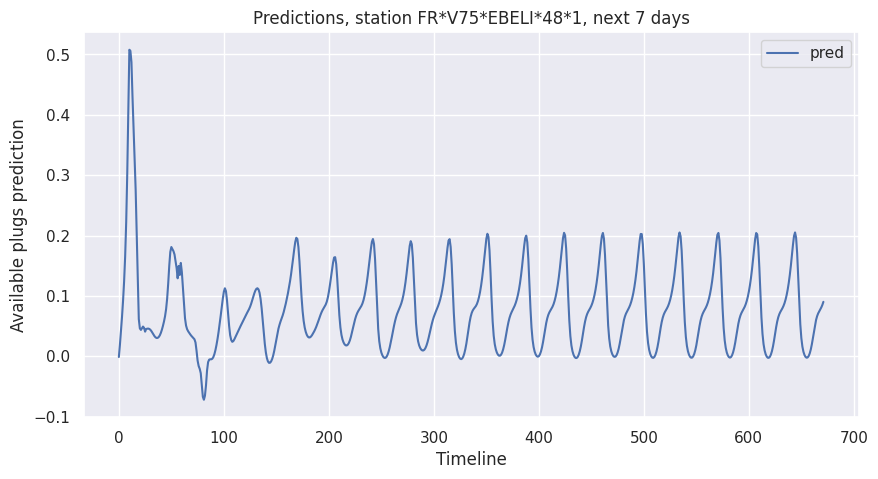

In [16]:
df_preds = pd.DataFrame({
    "pred": preds,
})

ax = df_preds.plot()

ax.set_xlabel("Timeline")
ax.set_ylabel("Available plugs prediction")
ax.set_title(f"Predictions, station {most_frequent_station}, next {DATA_POINTS_TO_PREDICT / 96:,.0f} days")

plt.show()

## Save model

In [17]:
MODEL_PATH = f"./models/col_{Y_COLUMN}_{MODEL_INDEX}.h5"

model.save(MODEL_PATH)

# load model like this:
# model = load_model("path/to/model.h5")

## Results

- Model trained.